# Search for Runaways



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import os
os.getcwd()

'/home/kevin_leo_mcmanus/repos/runawaysearch'

## Load up Stars, Cluster Info

In [3]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [4]:
# gaiadr2 to gaiaedr3 mapper
from  gaiastars import gaiadr2xdr3

In [5]:
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

## Collect GAIA Sample Data

In [7]:
cluster_names = ['Pleiades', 'alphaPer']
search_results = {}

from gaiastars import from_pickle

for cl in cluster_names:
    search_results[cl] = from_pickle(f'./data/search_results_{cl}.pkl')


In [8]:
#exclude the known members returned from the search
for cl in cluster_names:
    merged_fs = search_results[cl].merge(cluster_members[cl])
    print(f'------ {cl} -------')
    print(merged_fs.objs.which.value_counts())
    fs = merged_fs.query('which == \'{} cone search\''.format(cl))
    fs.name = 'Search Results, Known Members excluded'
    search_results[cl] = fs

------ Pleiades -------
Pleiades cone search    107919
both                      1225
Pleiades                   101
Name: which, dtype: int64
------ alphaPer -------
alphaPer cone search    291664
both                       699
alphaPer                    41
Name: which, dtype: int64


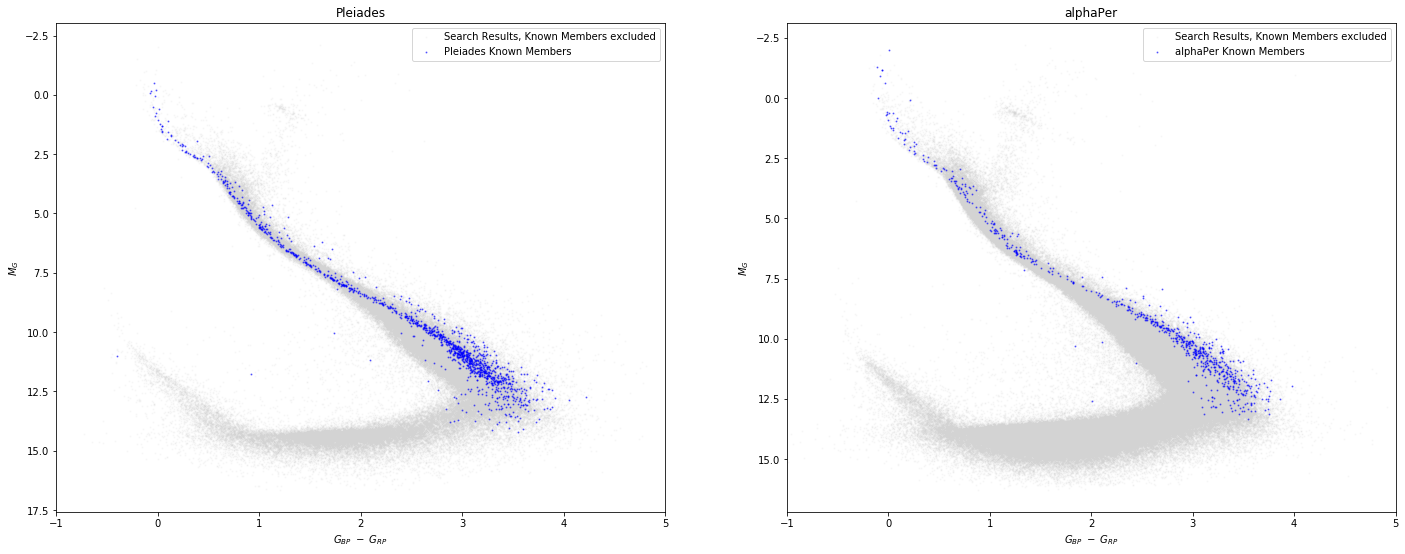

In [9]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl)
    ax[i].legend()


## 3 D Analysis

In [10]:
import pickle
coeval_results = {}
travel_times = {}

for cl in cluster_names:
    with open(f'./data/coeval_{cl}.pkl', 'rb') as pkl:
        coeval_results[cl]=pickle.load(pkl)
    with open(f'./data/travel_time_{cl}.pkl', 'rb') as pkl:
        travel_times[cl] = pickle.load(pkl)
    search_results[cl].objs = pd.concat([search_results[cl].objs, coeval_results[cl], travel_times[cl]], axis=1)
    search_results[cl].objs['Candidate_3d'] = np.logical_and(search_results[cl].objs.min_sep <= 20,
                                                    np.logical_and(search_results[cl].objs.lookback_time >= 70e6,
                                                                  search_results[cl].objs.lookback_time <= 130e6))

In [13]:
travel_times['alphaPer'].query('tt_3d_candidate')

,tt_3d_candidate,tt_3d_min,rv_min,tt_3d_max,rv_max
source_id,,,,,
66864364401034368,True,5.694165e+07,8.36,8.453979e+07,11.72
69097713030992256,True,5.694847e+07,6.88,7.494315e+07,9.32
69399288456115072,True,5.669681e+07,7.92,8.280123e+07,9.68
69912584291549440,True,5.718200e+07,7.80,8.410408e+07,11.12
70068650520031104,True,5.751367e+07,8.28,8.422064e+07,10.44
...,...,...,...,...,...
996893486002670592,True,5.664997e+07,2.08,5.725131e+07,2.52
997087206207079936,True,5.679009e+07,0.20,8.418052e+07,4.28
999057118727049088,True,5.665035e+07,0.64,5.803949e+07,1.44


In [18]:
travel_times['alphaPer'].query('~tt_3d_candidate').head()

,tt_3d_candidate,tt_3d_min,rv_min,tt_3d_max,rv_max
source_id,,,,,
62970959365145088,False,NaN,NaN,NaN,NaN
62973295826092672,False,NaN,NaN,NaN,NaN
62976040309623808,False,NaN,NaN,NaN,NaN
62977144118040960,False,NaN,NaN,NaN,NaN
62977659514111616,False,NaN,NaN,NaN,NaN


In [16]:
10**cluster_info.loc['alphaPer']['log_age']*np.array([0.8,1.2])

array([56635662.75073099, 84953494.12609649])

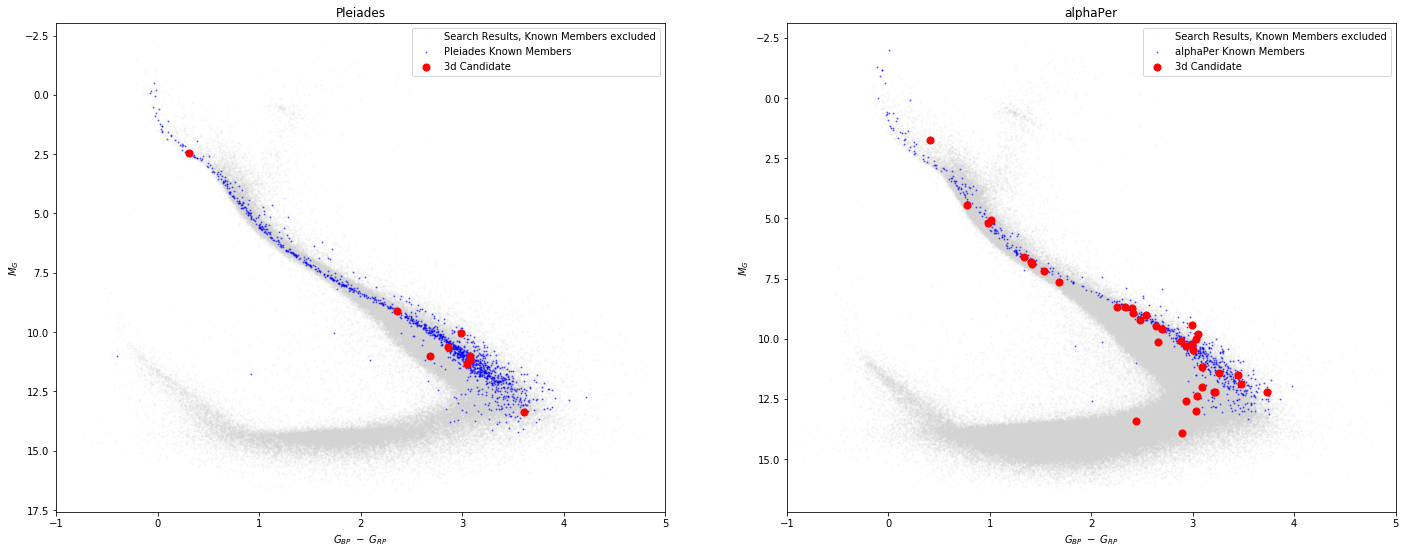

In [17]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    search_results[cl].query('Candidate_3d').plot_hrdiagram(ax=ax[i],color='red',s=50, alpha=1.0, r_est=False,label='3d Candidate')
    ax[i].set_title(cl)
    ax[i].legend()

## Color Model

In [25]:
from colormagmodel import cm_model

#fit the color models
cm_models = {}
for cl in cluster_names:
    cm_models[cl] = cm_model(f'{cl} Color Model')
    cm_models[cl].fit(*cluster_members[cl].get_colors())

In [26]:
for cl in cluster_names:
    cm_ok = cm_models[cl].predict(*search_results[cl].get_colors())
    search_results[cl].objs['ColorMag'] =cm_ok

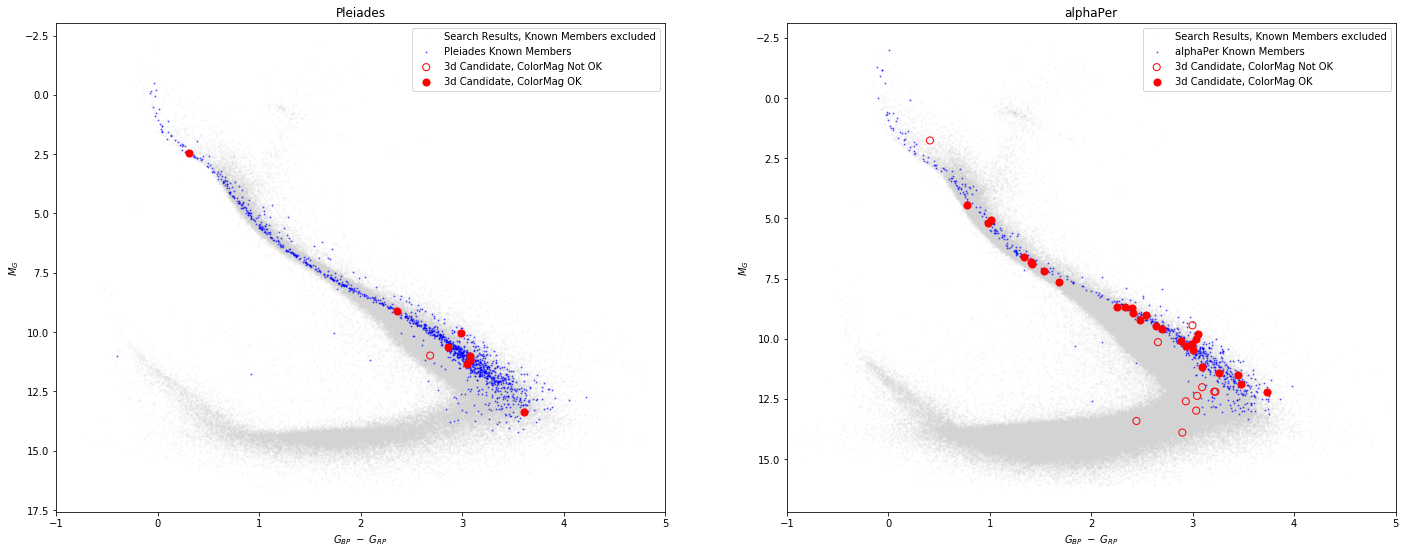

In [29]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    search_results[cl].query('Candidate_3d and ~ColorMag').plot_hrdiagram(ax=ax[i],s=50, alpha=1.0, r_est=False,
                                                                          label='3d Candidate, ColorMag Not OK',
                                                           facecolor='none', edgecolor='red')
    search_results[cl].query('Candidate_3d and ColorMag').plot_hrdiagram(ax=ax[i],s=50, alpha=1.0, r_est=False,
                                                                         label='3d Candidate, ColorMag OK',
                                                           facecolor='red', edgecolor='red')
    ax[i].set_title(cl)
    ax[i].legend()

## Evaluate `travel_time` Relationship

In [10]:
tt_thresh=0.7e8

for cl in cluster_names:
    search_results[cl].travel_time(cluster_info.loc[cl]['coords'], inplace=True)

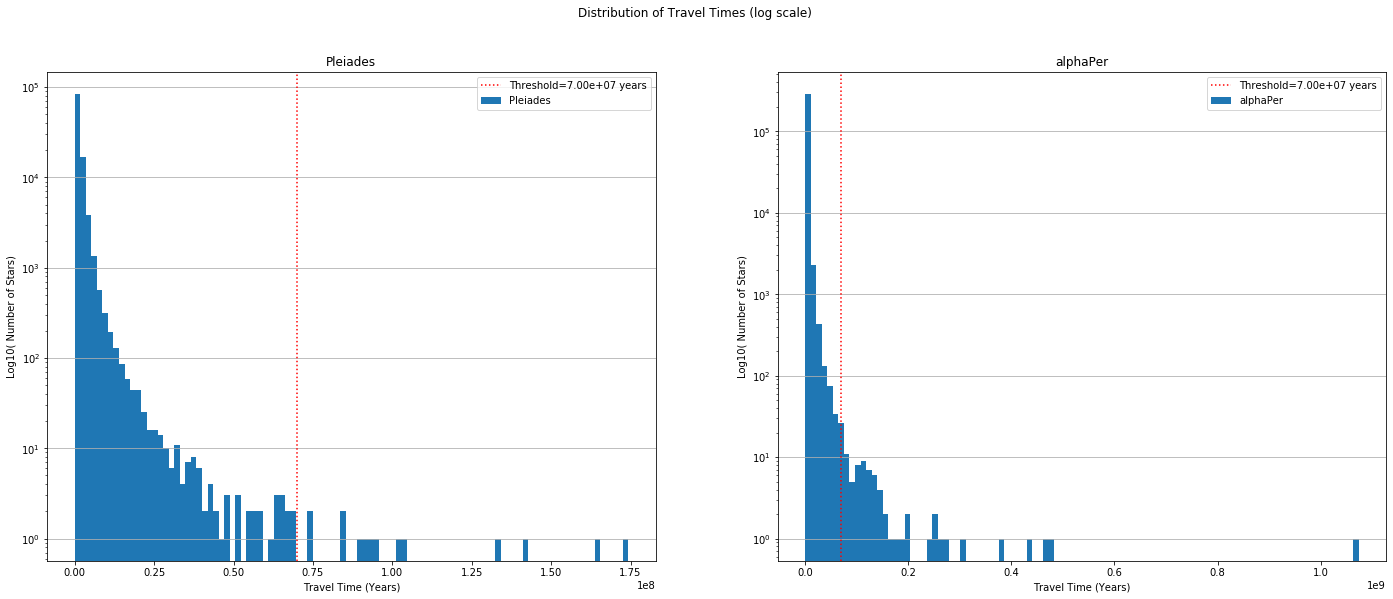

In [11]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    ax[i].hist(search_results[cl].objs.travel_time, bins=100, log=True, label=cl)
    ax[i].set_title(cl)
    ax[i].set_xlabel('Travel Time (Years)')
    ax[i].set_ylabel('Log10( Number of Stars)')

    ax[i].grid(axis='y')
    ax[i].axvline(tt_thresh, color='red', ls=":", label=f'Threshold={tt_thresh:.2e} years')
    ax[i].legend()
zz = fig.suptitle('Distribution of Travel Times (log scale)')

In [12]:
for cl in cluster_names:
    n_tt = len(search_results[cl].objs.query('travel_time>@tt_thresh'))
    n = len(search_results[cl].objs)
    print(f'Cluster: {cl}, Total Candidates: {n:,}, Travel Time > {tt_thresh:.2e}: {n_tt:,}, Percent: {100.0*n_tt/n:.2f}')

Cluster: Pleiades, Total Candidates: 107,919, Travel Time > 7.00e+07: 14, Percent: 0.01
Cluster: alphaPer, Total Candidates: 291,664, Travel Time > 7.00e+07: 77, Percent: 0.03


## Evaluate `points_to` Relationship

In [13]:
for cl in cluster_names:
    maxsep = cluster_members[cl].maxsep(center = cluster_info.loc[cl]['coords'] )
    search_results[cl].points_to(cluster_info.loc[cl]['coords'],maxsep.value, inplace=True, allcalcs=False)
    n_pt = len(search_results[cl].objs.query('points_to'))
    n = len(search_results[cl].objs)
    print(f'Cluster: {cl}, Total Candidates: {n:,}, Cluster Radius: {maxsep.degree:.2f} degree, Points_to {n_pt:,}, Percent: {100.0*n_pt/n:.2f}')



Cluster: Pleiades, Total Candidates: 107,919, Cluster Radius: 6.49 degree, Points_to 19,480, Percent: 18.05
Cluster: alphaPer, Total Candidates: 291,664, Cluster Radius: 5.25 degree, Points_to 54,940, Percent: 18.84


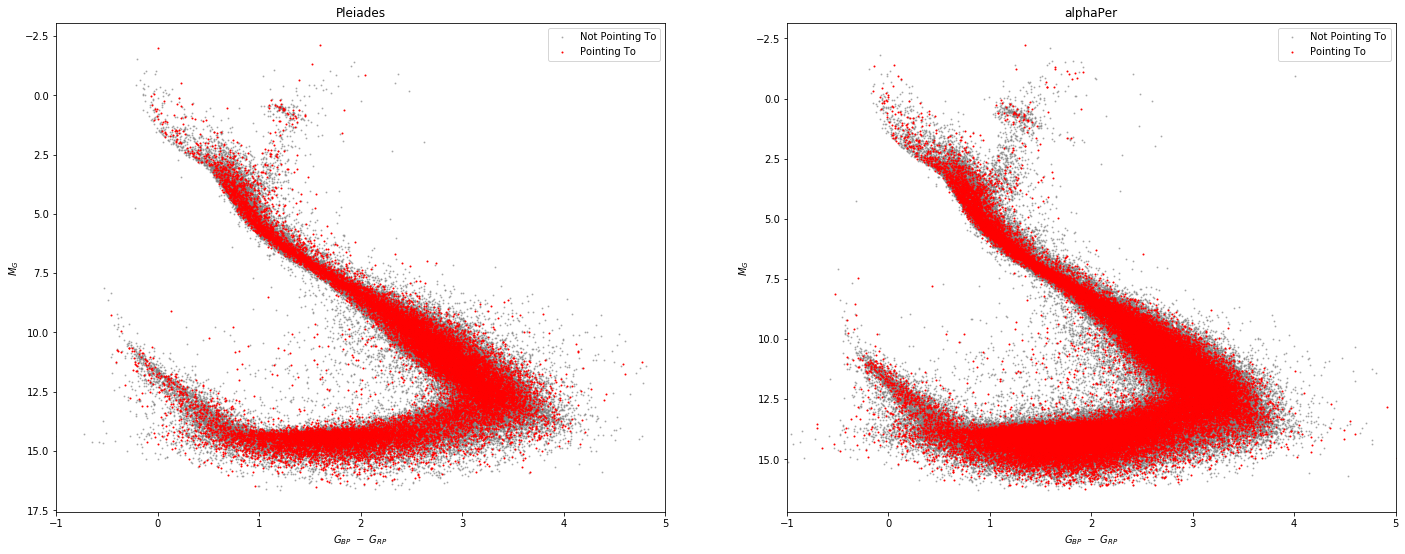

In [14]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('~points_to').plot_hrdiagram(ax=ax[i], color='grey', alpha=0.5, s=1, label="Not Pointing To")
    search_results[cl].query('points_to').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=1, label='Pointing To')
    ax[i].set_title(cl)
    ax[i].legend()

## Color Model

In [16]:
for cl in cluster_names:
    cm_ok = cm_models[cl].predict(*search_results[cl].get_colors())
    search_results[cl].objs['ColorMag'] = np.logical_and(cm_ok, search_results[cl].objs.points_to)
    
    #apply age filter
    search_results[cl].objs['TBTok'] = np.logical_and(search_results[cl].objs.ColorMag, search_results[cl].objs.travel_time >= tt_thresh)

In [17]:
#summarize results
for cl in cluster_names:
    scores = np.array([search_results[cl].objs.points_to, search_results[cl].objs.ColorMag, search_results[cl].objs.TBTok]).sum(axis=0)
    search_results[cl].objs['Score'] = scores

## Plot Results

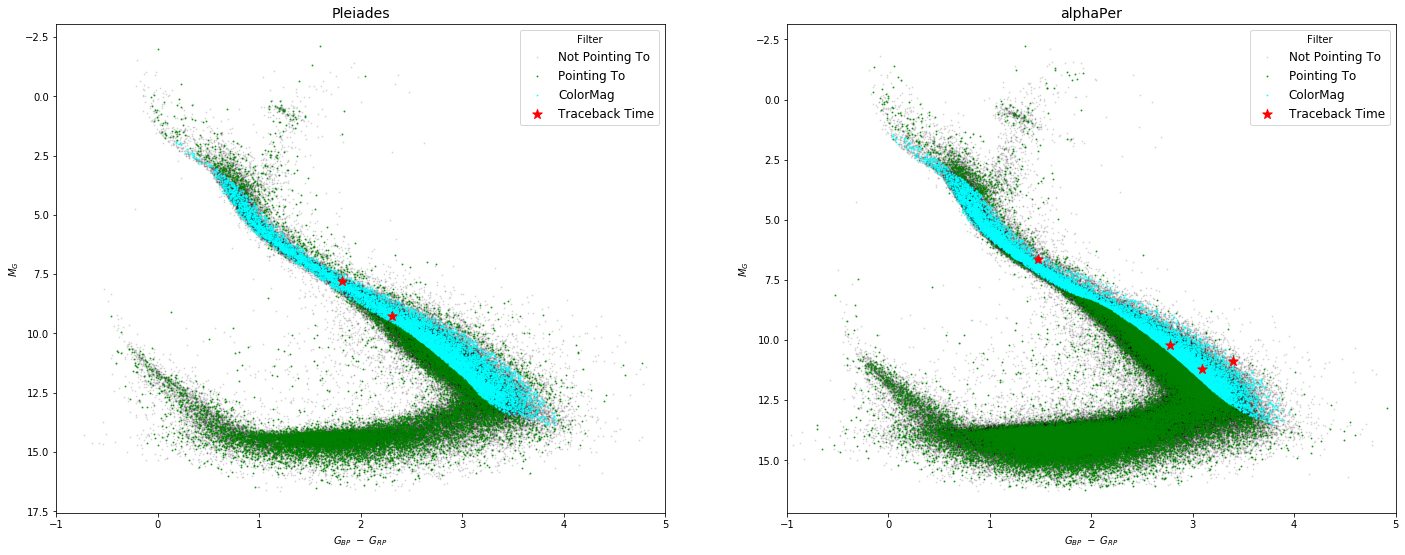

In [18]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,2)
for i, cl in enumerate(cluster_names):
    search_results[cl].query('Score == 0').plot_hrdiagram(ax=ax[i], color='black', alpha=0.1, s=1, label="Not Pointing To")
    #cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members', alpha=0.5, s=1)
    search_results[cl].query('Score == 1').plot_hrdiagram(ax=ax[i], color='green', alpha=0.7, s=1, label="Pointing To")
    search_results[cl].query('Score == 2').plot_hrdiagram(ax=ax[i], color='cyan', alpha=0.7, s=1, label="ColorMag")
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax[i], color='red', alpha=1, s=100,marker='*', label="Traceback Time")

    ax[i].set_title(cl, fontsize=14)
    ax[i].legend(fontsize=12, title='Filter')

In [19]:
filters = ['SearchResults','PointingTo','ColorModel','TracebackTime']
for i,f in enumerate(filters):
    n_Pleiades = len(search_results['Pleiades'].objs.query('Score >= @i'))
    n_alphaPer = len(search_results['alphaPer'].objs.query('Score >= @i'))
    print(f'Measure: {f}, Pleiades: {n_Pleiades}, alphaPer: {n_alphaPer}')

Measure: SearchResults, Pleiades: 107919, alphaPer: 291664
Measure: PointingTo, Pleiades: 19480, alphaPer: 54940
Measure: ColorModel, Pleiades: 8548, alphaPer: 10899
Measure: TracebackTime, Pleiades: 2, alphaPer: 4


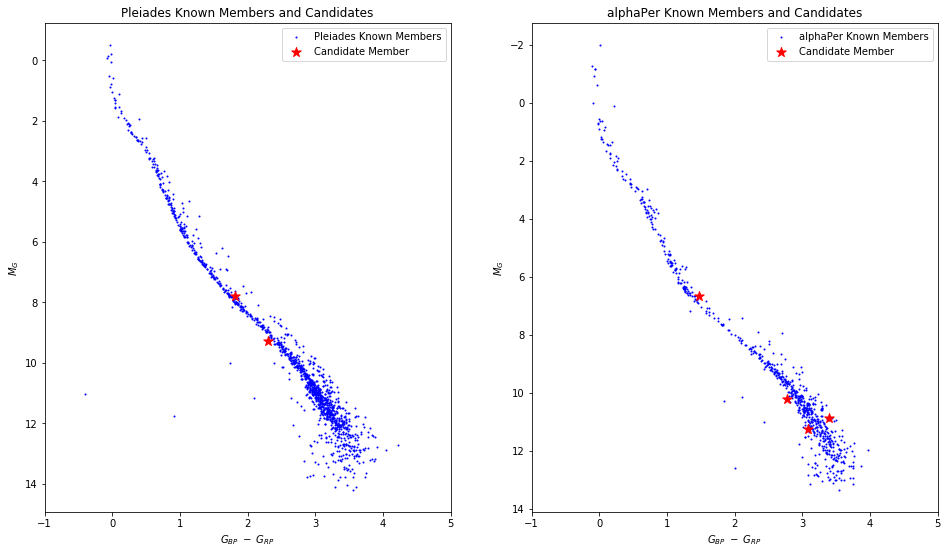

In [20]:
fig = plt.figure(figsize=(16,9))
axs = fig.subplots(1,2)

for ax,cl in zip(axs, cluster_names):
    cluster_members[cl].plot_hrdiagram(ax=ax, color='blue', label=f'{cl} Known Members', alpha=1, s=1)
    search_results[cl].query('Score == 3').plot_hrdiagram(ax=ax, color='red', alpha=1, s=100,marker='*', label="Candidate Member")

    ax.legend()
    ax.set_title(f'{cl} Known Members and Candidates')

## Trajectory

In [21]:
def cartesian_to_spherical(xyz):
    r = np.sqrt((xyz**2).sum(axis=0))
    delta = np.arctan(xyz[2]/np.sqrt(xyz[0]**2+xyz[1]**2))
    alpha = np.arctan2(xyz[1], xyz[0])
    alpha = np.where(alpha<0, alpha+2.0*np.pi, alpha)
    
    spherical = {'distance':r,
                 'alpha': np.rad2deg(alpha),
                 'delta': np.rad2deg(delta)
    }
    
    return spherical

In [22]:
def get_trajectory(coord, tval, default_rv= 5*u.km/u.second):
    c = coord.galactic
    xyz = c.cartesian.xyz.reshape(-1,1) # in pc
    
    pm_l_cosb = c.pm_l_cosb
    pm_b = c.pm_b
    
    d_xyz = c.velocity.d_xyz.to(u.pc/u.year).reshape(-1,1)
    
    xyz_t = xyz + d_xyz.dot(tval)
    
    spherical = cartesian_to_spherical(xyz_t.value)
    
    return spherical

In [23]:
tval = np.linspace(-120e6, 0, 10001).reshape(1,-1)*u.year

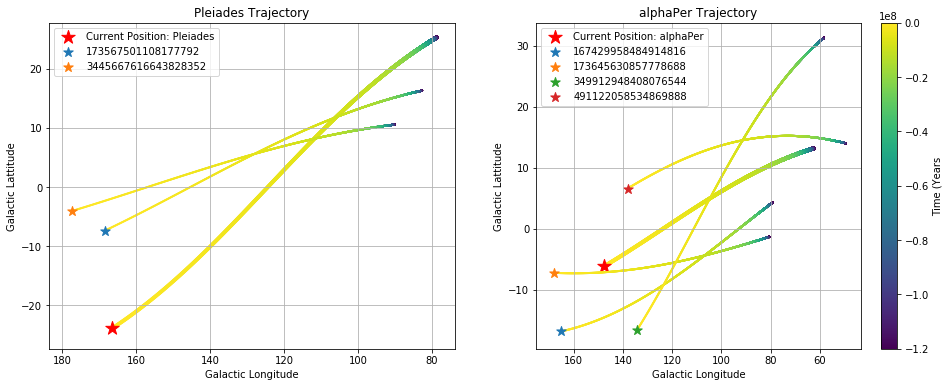

In [24]:
fig = plt.figure(figsize=(16,6))
axs = fig.subplots(1,2)

for cl,ax in zip(cluster_names, axs):
    c = cluster_info.loc[cl]['coords'].galactic
    sphere_t = get_trajectory(c, tval)
    
    pcm = ax.scatter(sphere_t['alpha'], sphere_t['delta'], s=8, c=tval[0])
    ax.scatter(c.l, c.b,s=200,marker='*', color='red', label=f'Current Position: {cl}')
    
    #plot trajectories of candidates:
    candidates = search_results[cl].query('Score == 3')
    cand_coords = candidates.get_coords().galactic
    for i, c in enumerate(cand_coords):
        sphere_t = get_trajectory(c, tval)
        ax.scatter(sphere_t['alpha'], sphere_t['delta'], s=1, c=tval[0])
                   
        ax.scatter(c.l, c.b,s=100,marker='*',label=list(candidates.objs.index)[i])
                   
    #ax.arrow(l_arrow, b_arrow, dl_arrow, db_arrow, head_width=1, color='red')
    #ax.text(0.95*(l_arrow+dl_arrow/2), b_arrow+db_arrow/2, 'Direction of Travel',color='red')
    ax.set_title(f'{cl} Trajectory')
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Lattitude')
    ax.legend()
    ax.grid()
    ax.invert_xaxis()
fig.colorbar(pcm, label='Time (Years')

In [25]:
candidates.objs.TraceBackTime

AttributeError: 'DataFrame' object has no attribute 'TraceBackTime'

In [30]:
def pm_to_dxyz(ra, dec, distance, pm_ra_cosdec, pm_dec, radial_velocity):
    """
    computes d_xyz from ra, dec,d distance, pmra_cosdec and pm_dec, given a sample of radial velocity
    Arguemnts:
  
    """
    v_ra = (pm_ra_cosdec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    v_dec = (pm_dec.to(u.radian/u.year)*distance*(1/u.radian)).to(u.km/u.s)
    
    #form the derivative matrix
    sin_alpha = np.sin(ra); cos_alpha = np.cos(ra)
    sin_delta = np.sin(dec); cos_delta=np.cos(dec)
    
    #shape should be 3x3
    dm = np.array([cos_delta*cos_alpha, -sin_alpha,   -sin_delta*cos_alpha,
                  cos_delta*sin_alpha,   cos_alpha,   -sin_alpha*sin_delta,
                  sin_delta,             0,            cos_delta]).reshape(3,3)

    n = len(radial_velocity)
    eq_v = np.array([radial_velocity.value, np.full(n,v_ra.value), np.full(n, v_dec.value)]) *u.km/u.second
    d_xyz = dm.dot(eq_v)
    
    return d_xyz

In [31]:
def valid_rv(star, center, tt_min, rv_sample):
    """
    returns boolean vector indicating which members of rv_sample allow for a travel time from center to star greater than mintt
    """
    
    #get velocity column vectors for star for each element of rv_sample
    d_xyz_s = pm_to_dxyz(star.ra, star.dec, star.distance, star.pm_ra_cosdec, star.pm_dec, rv_sample)
    
    #center velocity column vector
    d_xyz_c = center.velocity.d_xyz.reshape(3,1)
    #velocity in center reference frame
    d_xyz_s_csr = d_xyz_s - d_xyz_c
    
    #space velocity and convert to pc/year
    vel_csr = np.sqrt((d_xyz_s_csr**2).sum(axis=0)).to(u.pc/u.year)
    
    #distance btwn center and star
    d=center.separation_3d(star) #comes back in pc
    
    #how long did it take given the sample of velocities
    tt_sample = d/vel_csr # should be in years
    
    rv_valid = tt_sample >= tt_min
    
    return rv_valid, tt_sample

In [32]:
def separation_t( star, center, rv, travel_time):
    """
    calculates separation of center and star at each of the (traveltime, rv) pair
    travel_time is signed quantity <0 => time in past; >0 => time in future
    """
    tt = travel_time.to(u.year).reshape(1,-1)
    
    cen_pos = center.cartesian.xyz.reshape(3,1)
    cen_d_xyz = center.velocity.d_xyz.reshape(3,1).to(u.pc/u.year)
    
    cen_delta_pos = cen_d_xyz.dot(tt)
    cen_pos_t = cen_pos + cen_delta_pos
    
    star_pos = star.cartesian.xyz.reshape(3,1)
    star_d_xyz = pm_to_dxyz(star.ra, star.dec, star.distance, star.pm_ra_cosdec, star.pm_dec, rv)
    tt_stack = np.vstack([tt]*3)
    star_delta_pos = star_d_xyz*tt_stack
    star_pos_t = star_pos+star_delta_pos
    
    #calculate the separations
    delta_xyz = star_pos_t - cen_pos_t
    seps = np.sqrt((delta_xyz**2).sum(axis=0))
    
    return seps

In [33]:
def traceback3d(star, center, tidal_r, rvsample):
    v_rv, tt_sample= valid_rv(star, center,  20e6*u.year, rvsample)
    
    seps = separation_t(star, center, rvsample, -1*tt_sample)
    
    valid_seps = seps <= tidal_r
    min_sep_i = seps.argmin()
    min_sep = seps[min_sep_i]
    min_sep_time = -1.0*tt_sample[min_sep_i]

    if np.any(valid_seps):
        rv_i = np.arange(len(rvsample))
        #get max travel time for seps <= tidal_r
        am = tt_sample[valid_seps].argmax()
        am_i = rv_i[valid_seps][am]
        rv = rvsample[am_i].value
        tt = tt_sample[am_i].value
    else:
        rv =  tt = np.nan
    
    return {'RequiredRadialVelocity': rv, 'ImpliedTravelTime': tt, 'MinSeparation':min_sep, 'MinSepTime':min_sep_time}

In [34]:
rv_sample3 = np.concatenate([np.linspace(-100, -20, 800, endpoint=False),
                        np.linspace(-20,20,1000, endpoint=False),
                        np.linspace(20, 100, 800)])*u.km/u.second

In [35]:
candidates = {}
tb_results = {}
for cl in cluster_names:
    candidates[cl] = search_results[cl].query('Score == 3')
    coords = candidates[cl].get_coords(recalc=True, default_rv=True)
    tb_results[cl] = pd.DataFrame([traceback3d(c, cluster_info.loc[cl]['coords'], 10*u.pc, rv_sample3) for c in coords],
                                 index = pd.Index(list(candidates[cl].objs.index), name =search_results[cl].objs.index.name ))


In [36]:
tb_results['Pleiades']

,RequiredRadialVelocity,ImpliedTravelTime,MinSeparation,MinSepTime
source_id,,,,
173567501108177792,NaN,NaN,25.59338549672953 pc,-6293469.0335414205 yr
3445667616643828352,NaN,NaN,49.36523955080671 pc,-3362257.300545691 yr


In [37]:
tb_results['alphaPer']

,RequiredRadialVelocity,ImpliedTravelTime,MinSeparation,MinSepTime
source_id,,,,
167429958484914816,NaN,NaN,79.60640438464276 pc,-548796.4041934276 yr
173645630857778688,NaN,NaN,38.875978507569585 pc,-5181938.238139662 yr
349912948408076544,NaN,NaN,50.562230590243026 pc,-1278323.328712422 yr
491122058534869888,NaN,NaN,60.6098976035135 pc,-454874.5497552773 yr


In [38]:
def plot_rv(ax,star, center, source_id, rvsample, ttsample, seps, tidal_radius=10*u.pc, xlim=None):
    #color boundaries
    vmin = 10e6; vmax=100e6


    current_sep = star.separation_3d(center)
    act_rv = star.radial_velocity.value

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

    ax.scatter(rvsample, ttsample, label=f'Source ID: {source_id}',
               c=ttsample, cmap='RdYlGn',  vmin=vmin, vmax=vmax, ls='-')
    ax.axvline(act_rv, color='orange', ls='--', label='Observed RV')
    ax.tick_params( axis='x', which='both', bottom='on', top='on', labelbottom='off' )    
    ax.set_ylabel('Travel Time to Current Separation (Years)')

    ax.set_title(f'Source ID: {source_id}')
    ax.legend()
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_xticklabels([])

    divider = make_axes_locatable(ax)
    ax1 = divider.append_axes("bottom", size="50%", pad=0.08)
    cax = divider.append_axes("right", size="5%", pad=0.08)


    pcm = ax1.scatter(rvsample, seps, c=tt_sample,cmap='RdYlGn',  vmin=vmin, vmax=vmax,
                      label='Modeled')
    ax1.axvline(act_rv, color='orange', ls='--', label='Observed RV')
    ax1.axhline(current_sep.value, color='red', ls='--', label='Current Separation')
    ax1.axhline(tidal_radius.value, color='blue', ls='--', label='Tidal Radius')
    ax1.set_xlabel('Radial Velocity (km/s)')
    ax1.set_ylabel('Separation at Current Sep Travel Time (pc)')
    ax1.grid()
    ax1.legend()
    ax1.set_xlim(xlim)
    #zz=ax[1].set_title('Separation')
    cb = plt.colorbar( pcm, ax=ax1, cax=cax )
    cb.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
    cb.ax.set_ylabel('Travel Time (Years)', rotation=-90)

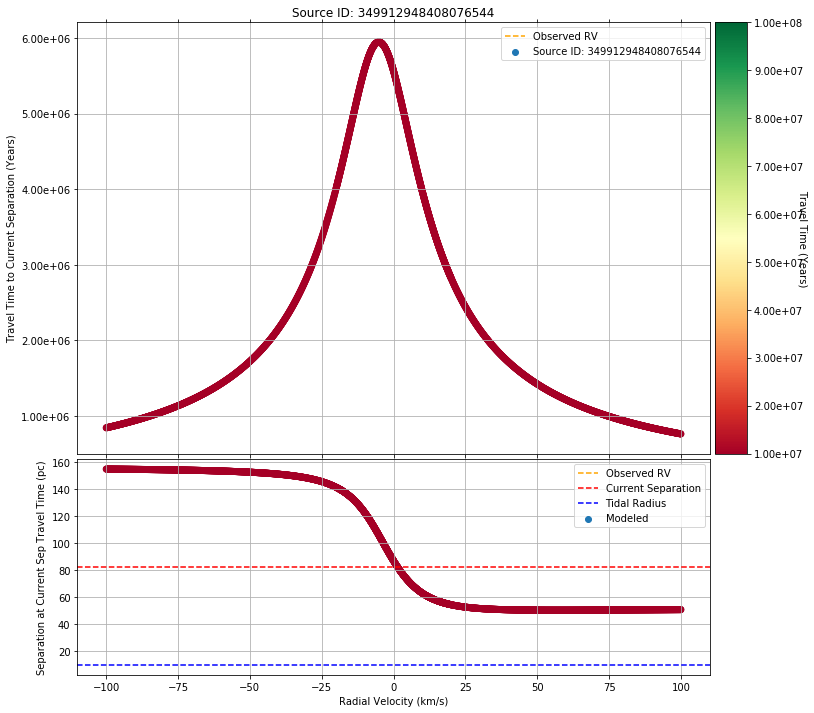

In [39]:
cl='alphaPer'
source_id = 349912948408076544

candidates[cl] = search_results[cl].query('Score == 3')
coords = candidates[cl].get_coords(recalc=True, default_rv=True)
star_i = candidates[cl].objs.index.get_loc(source_id)

v_rv, tt_sample= valid_rv(coords[star_i],cluster_info.loc[cl]['coords'],20e6*u.year,rv_sample3)
seps = separation_t(coords[star_i],cluster_info.loc[cl]['coords'],rv_sample3, -1*tt_sample)

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
plot_rv(ax,coords[star_i], cluster_info.loc[cl]['coords'], source_id, rv_sample3, tt_sample, seps, xlim=None)

In [40]:
candidates['alphaPer']

GaiaStars Object, Name: Search Results, Known Members excluded, Description: None with query: which == 'alphaPer cone search' with query: Score == 3, 4 objects

In [41]:
candidates['alphaPer'].travel_time3d(cluster_info.loc['alphaPer']['coords'], 50e6*u.year)

,tt_3d_candidate,tt_3d_min,rv_min,tt_3d_max,rv_max
source_id,,,,,
167429958484914816,False,NaN,NaN,NaN,NaN
173645630857778688,False,NaN,NaN,NaN,NaN
349912948408076544,False,NaN,NaN,NaN,NaN
491122058534869888,False,NaN,NaN,NaN,NaN


In [47]:
candidates['alphaPer']._travel_time3d(coords[0],cluster_info.loc['alphaPer']['coords'], 10e6*u.year, rv_sample3)

{'tt_3d_candidate': True,
 'tt_3d_min': 10021478.32018587,
 'rv_min': 3.5199999999999996,
 'tt_3d_max': 24056345.10568817,
 'rv_max': 8.96}

In [45]:
rv, tt = candidates['alphaPer']._travel_time3d(coords[0],cluster_info.loc['alphaPer']['coords'],    10e6*u.year, rv_sample3, ret_sample=True)

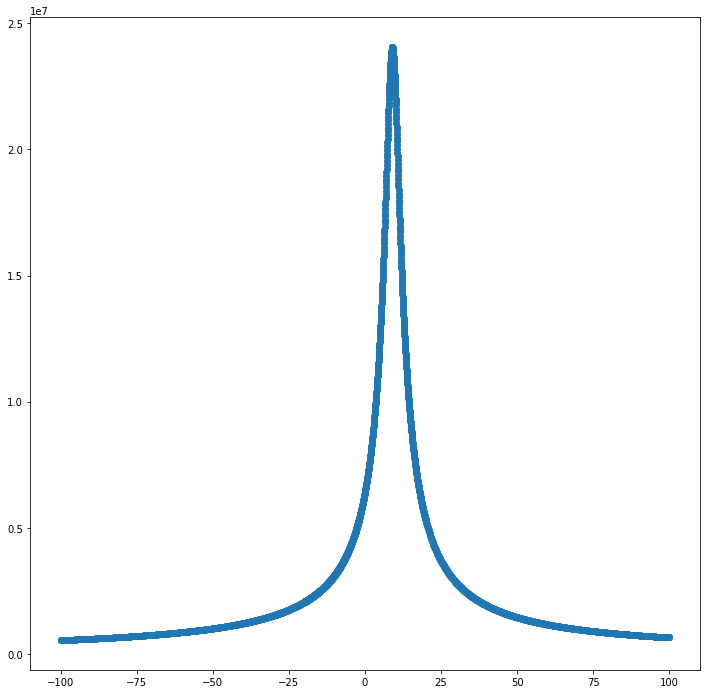

In [46]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.scatter(rv, tt)